In [1]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib
import math
from scipy import integrate
from cvxopt import matrix, solvers
import networkx as nx
from itertools import repeat

# Data Loading

In [2]:
global train_inp_B, train_out_B, val_inp_B, val_out_B, test_inp_B, test_out_B, t
train_inp_B = np.load('nba_train_inp_B.npy')
train_out_B = np.load('nba_train_out_B.npy')
val_inp_B = np.load('nba_val_inp_B.npy')
val_out_B = np.load('nba_val_out_B.npy')
test_inp_B = np.load('nba_test_inp_B.npy')
test_out_B = np.load('nba_test_out_B.npy')
t = np.load('t.npy')

In [3]:
global n, N #n is the number of nodes, N is the number of basis 
n = 21
d = 2
N = 80
global REG
REG = "MCP"
global op_gamma_list, Lambda_list, Gamma_list, Rho_list, Beta_list
op_gamma_list1 = [1.]
op_gamma_list2 = [1.]
op_gamma_list = np.transpose([np.tile(op_gamma_list1, len(op_gamma_list2)), np.repeat(op_gamma_list2, len(op_gamma_list1))])
Lambda_list = [1.]
Gamma_list1 = [1e-2]
Gamma_list2 = [1e-2]
Gamma_list = np.transpose([np.tile(Gamma_list1, len(Gamma_list2)), np.repeat(Gamma_list2, len(Gamma_list1))])
Rho_list = [1.]
Beta_list = [1e-1]

In [4]:
global num_train, num_val, num_test
num_train = train_inp_B.shape[1]
num_val = val_inp_B.shape[1]
num_test = test_inp_B.shape[1]
print(num_train)
print(num_val)
print(num_test)

233
59
59


# Basis Selection and Projection on basis functions with integration routine

In [5]:
def trig_basis():
    basis = []
    for i in range(N):
        if i == 0:
            b = (1./np.sqrt(t[-1]))*np.ones(len(t))
        else:
            b = np.sqrt(2./t[-1])*np.cos(np.pi*i*((1./t[-1])*t))
        basis.append(b)
    return basis

In [6]:
global basis
#global k_mat
basis = trig_basis()

In [7]:
def get_proj_coefs(x):
    proj = np.zeros(N)
    for i in range(N):
        proj[i] = inner_prod(x, basis[i])
    return proj

In [8]:
def inner_prod(f, g):
    s = 0.
    num_t = len(f)
    x = t
    dx = (t[-1] - t[0])/(num_t-1)
    fx = f*g
    s = integrate.simps(fx, x, dx, even='avg')
    return s

In [9]:
def inner_prod_2d(mat, basis_i, basis_j):
    x = t
    num_t = len(t)
    dx = (t[-1] - t[0])/(num_t-1)
    s_t = np.zeros(num_t)
    for i in range(num_t):
        fx = mat[:,i]*basis_j
        s_t[i] = integrate.simps(fx, x, dx, even='avg')
    fx = s_t*basis_i
    s = integrate.simps(fx, x, dx, even='avg')
    return s

In [10]:
def exp_kernel_encoding_multi_d(exp_mat):
    k_mat = np.zeros((d,N,N))
    for d1 in range(d):
        for i in range(N):
            for j in range(i,N):
                k_mat[d1][i][j] = inner_prod_2d(exp_mat[d1], basis[i], basis[j])
                if i!=j:
                    k_mat[d1][j][i] = k_mat[d1][i][j]
    return k_mat

In [11]:
def exp_kernel_encoding(exp_mat):
    k_mat = np.zeros((N,N))
    for i in range(N):
        for j in range(i,N):
            k_mat[i][j] = inner_prod_2d(exp_mat, basis[i], basis[j])
            if i!=j:
                k_mat[j][i] = k_mat[i][j]
    return k_mat

# Scalar and Operator-valued Kernel

In [12]:
def scalar_kernel_without_M_dup(f, g, M_dup_c):
    inner_prod_matrix = np.zeros((n,n))
    for i in range(n):
        for j in range(i,n):
            inner_prod_matrix[i][j] = np.dot(f[i]-g[i], f[j]-g[j])
            if i!=j:
                inner_prod_matrix[j][i] = inner_prod_matrix[i][j]
    vec_inner_prod = inner_prod_matrix.flatten()
    r = np.zeros(int(n*(n+1)/2))
    for i in range(int(n*(n+1)/2)):
        c_ones = M_dup_c[i]
        for j in c_ones:
            if j!= -1:
                r[i] += vec_inner_prod[j]
    return r

In [13]:
def scalar_inner_prod_without_M_dup(f, M_dup_c):
    inner_prod_matrix = np.zeros((n,n))
    for i in range(n):
        for j in range(i,n):
            inner_prod_matrix[i][j] = np.dot(f[i], f[j])
            if i!=j:
                inner_prod_matrix[j][i] = inner_prod_matrix[i][j]
    vec_inner_prod = inner_prod_matrix.flatten()
    r = np.zeros(int(n*(n+1)/2))
    for i in range(int(n*(n+1)/2)):
        c_ones = M_dup_c[i]
        for j in c_ones:
            if j!= -1:
                r[i] += vec_inner_prod[j]
    return r

In [14]:
def scalar_inner_prod_for_z(f, g):
    r = np.zeros(n)
    for i in range(n):
        r[i] = np.dot(f[i]-g[i], f[i]-g[i])
    return r

In [15]:
def scalar_kernel_calc(Gamma, R, vech_L, i, j):
    return i,j,np.exp(-Gamma*np.dot(R[i][j],vech_L))

In [16]:
def scalar_G1(vech_L, R, Gamma):#check for parallelization
    i_j_pair_arr = train_i_j_pair_arr
    n1 = num_train
    G = np.zeros((n1,n1))
    with concurrent.futures.ProcessPoolExecutor() as executor:
        for i,j,result in executor.map(scalar_kernel_calc, repeat(Gamma), repeat(R), repeat(vech_L), i_j_pair_arr[:,0], i_j_pair_arr[:,1]):
            G[i][j] = result
            if i!=j:
                G[j][i] = G[i][j]
    return G

In [17]:
def scalar_kernel_calc_normal_multi_d(Gamma, R, vech_L, D, Z, i, j):
    gamma_sum_dot_prods = 0.
    for d1 in range(d): #d is defined as a global variable 
        gamma_sum_dot_prods += Gamma[d1]*(np.dot(R[d1][i][j],vech_L) + np.dot(Z[d1][i][j], D)) 
    return np.exp(-gamma_sum_dot_prods)

In [18]:
def scalar_kernel_calc_normal(Gamma, R, vech_L, D, Z, i, j):
    return np.exp(-Gamma*(np.dot(R[i][j],vech_L) + np.dot(Z[i][j], D)))

In [19]:
def scalar_G1_normal_multi_d(vech_L, R, Gamma, D, Z, num_t):#check for parallelization
    G = np.zeros((num_t,num_t))
    for i in range(num_t):
        for j in range(i, num_t):
            G[i][j] = scalar_kernel_calc_normal_multi_d(Gamma, R, vech_L, D, Z, i, j)
            if i != j:
                G[j][i] = G[i][j]
    return G

In [20]:
def scalar_G1_normal(vech_L, R, Gamma, D, Z, num_train):
    G = np.zeros((num_train,num_train))
    for i in range(num_train):
        for j in range(i, num_train):
            G[i][j] = scalar_kernel_calc_normal(Gamma, R, vech_L, D, Z, i, j)
            if i != j:
                G[j][i] = G[i][j]
    return G

In [21]:
def scalar_G1_normal_subset(vech_L, R, Gamma, D, Z, num_train, row_indices, G):
    #G = np.zeros((num_train,num_train))
    for i in range(len(row_indices)):
        row_idx = row_indices[i]
        for j in range(row_idx, num_train):
            G[row_idx][j] = scalar_kernel_calc_normal(Gamma, R, vech_L, D, Z, row_idx, j)
            if row_idx != j:
                G[j][row_idx] = G[row_idx][j]
    return G

In [22]:
def scalar_G1_normal_subset_with_diag(vech_L, R, Gamma, D, Z, num_train, row_indices, G):
    for i in range(len(row_indices)):
        row_idx = row_indices[i]
        for j in range(len(row_indices)):
            col_idx = row_indices[j]
            if row_idx!=col_idx:
                G[row_idx][col_idx] = scalar_kernel_calc_normal(Gamma, R, vech_L, D, Z, row_idx, col_idx)
                G[col_idx][row_idx] = G[row_idx][col_idx]

    for i in range(num_train):
        G[i][i] = scalar_kernel_calc_normal(Gamma, R, vech_L, D, Z, i, i)
        
    return G

In [23]:
def op_kernel(z, op_gamma):
    y = np.zeros(len(basis[0]))
    for i in range(len(basis)):
        y += z[i]*basis[i]
    one = np.ones(len(y))
    X = np.zeros(y.shape)
    for i in range(len(y)):
        s = t
        dx = t[-1]/(len(y)-1)
        f = np.multiply(np.exp(-op_gamma*np.abs(t[i]*one-s)),y)
        X[i] = integrate.simps(f, s, dx, even='avg')
    fX = get_proj_coefs(X)
    return fX

In [24]:
def op_kernel_modified(z, k_mat):
    return np.dot(k_mat,z)

In [25]:
def op_kernel_exp_multi_d(op_gamma):
    exp_mat = np.zeros((d,len(t),len(t)))
    for d1 in range(d):
        for i in range(len(t)):
            for j in range(len(t)):
                exp_mat[d1][i][j] = np.exp(-op_gamma[d1]*(np.abs(t[i]-t[j])))
    return exp_mat

In [26]:
def op_kernel_exp(op_gamma):
    exp_mat = np.zeros((len(t),len(t)))
    for i in range(len(t)):
        for j in range(len(t)):
            exp_mat[i][j] = np.exp(-op_gamma*(np.abs(t[i]-t[j])))
    return exp_mat

In [27]:
def op_K(u, op_gamma):
    n1 = len(u)
    K = []
    with concurrent.futures.ProcessPoolExecutor() as executor:
        for K_i in executor.map(op_kernel, u, repeat(op_gamma)):
            K.append(K_i)
    return K

In [28]:
def op_K_normal(u, op_gamma):
    n1 = len(u)
    K = []
    for i in range(n1):
        K.append(op_kernel(u[i], op_gamma))
    return K

In [29]:
def op_K_normal_modified_multi_d(u, k_mat):
    n1 = len(u[0])
    K = np.zeros((len(u), n1, N))
    for d1 in range(len(u)):
        for i in range(n1):
            K[d1][i] = op_kernel_modified(u[d1][i], k_mat[d1])
    return K

In [30]:
def op_K_normal_modified(u, k_mat):
    n1 = len(u)
    K = np.zeros((n1, N))
    for i in range(n1):
        K[i] = op_kernel_modified(u[i], k_mat)
    return K

In [31]:
def op_dot_A(G, v, op_gamma, Lambda):
    n1 = len(v)
    Av = np.zeros(v.shape)
    K = op_K_normal(v, op_gamma)
    for i in range(n1):
        X = 0.* v[0]
        for j in range(n1):
            if i == j:
                X += G[i,j]*(K[j]) + Lambda*(v[j])
            else:
                X += G[i,j]*(K[j])
        Av[i] = X
    return Av

In [32]:
def op_dot_A_modified_multi_d(G, v, Lambda, k_mat):
    Av = np.zeros(v.shape)
    for d1 in range(d):
        n1 = len(v[d1])
        K = op_K_normal_modified_multi_d(v, k_mat)
        for i in range(n1):
            X = 0.* v[d1][0]
            for j in range(n1):
                if i == j:
                    X += G[i][j]*(K[d1][j]) + Lambda*(v[d1][j])
                else:
                    X += G[i][j]*(K[d1][j])
            Av[d1][i] = X
    return Av

In [33]:
def op_dot_A_modified(G, v, Lambda, k_mat):
    n1 = len(v)
    Av = np.zeros(v.shape)
    K = op_K_normal_modified(v, k_mat)
    for i in range(n1):
        X = 0.* v[0]
        for j in range(n1):
            if i == j:
                X += G[i][j]*(K[j]) + len(v)*Lambda*(v[j])
            else:
                X += G[i][j]*(K[j])
        Av[i] = X
    return Av

# OpMINRES related functions

In [34]:
def LanczosStep_multi_d(G, v1, v0, beta1, Lambda):
    p = op_dot_A_modified_multi_d(G, v1, Lambda, k_mat)
    alpha = np.zeros((d,1))
    beta2 = np.zeros((d,1))
    v2 = np.zeros(v1.shape)
    for d1 in range(d):
        alpha[d1] = np.sum(np.multiply(v1[d1],p[d1]))
        p[d1] = p[d1] - alpha[d1]*v1[d1]
        v2[d1] = p[d1] - beta1[d1]*v0[d1]
    
        beta2[d1] = np.linalg.norm(v2[d1,:,:])
        if (beta2[d1] != 0):
            v2[d1,:,:] = (1./beta2[d1])*v2[d1,:,:]
    return alpha, beta2, v2

In [35]:
def LanczosStep(G, v1, v0, beta1, Lambda):
    p = op_dot_A_modified(G, v1, Lambda, k_mat)
    alpha = np.sum(np.multiply(v1,p))
    p = p - alpha*v1
    v2 = p - beta1*v0
    beta2 = np.linalg.norm(v2)
    if (beta2 != 0):
        v2 = (1./beta2)*v2
    return alpha, beta2, v2

In [36]:
def SymOrtho(a, b):
    if (b == 0):
        s = 0
        r = np.abs(a)
        if (a == 0):
            c = 1
        else:
            c = np.sign(a)
    elif (a == 0):
        c = 0
        s = np.sign(b)
        r = np.abs(b)
    elif (np.abs(b) > np.abs(a)):
        tau = a/b
        s = np.sign(b)/np.sqrt(1 + tau**2)
        c = s*tau
        r = b/s
    elif (np.abs(a) > np.abs(b)):
        tau = b/a
        c = np.sign(a)/np.sqrt(1 + tau**2)
        s = c*tau
        r = a/c
    return c, s, r

In [37]:
def OpMINRES_multi_d(G, b, maxiter, tol, Lambda):
    beta1 = np.zeros((d,1))
    for d1 in range(d):
        beta1[d1] = np.linalg.norm(b[d1,:,:]) #b is a 3d array 
        
    num_tr = len(b[0])
    v0 = np.zeros((d,num_tr,N))
    v1 = np.zeros((d,num_tr,N))
    for d1 in range(d):
        v1[d1] = (1./beta1[d1])*b[d1,:,:]
    
    phi0 = beta1
    phi1 = beta1
    phi00 = beta1
    tau = beta1
    
    chi = np.zeros((d,1))
    delta1_1 = np.zeros((d,1))
    epsilon1_1 = np.zeros((d,1))
    
    c0 = -1*np.ones((d,1))
    s0 = np.zeros((d,1))
    c1 = np.zeros((d,1))
    s1 = np.zeros((d,1))
    gamma1_2 = np.zeros((d,1))
    
    
    q0 = np.zeros((d,num_tr,N))
    q1 = np.zeros((d,num_tr,N))
    q2 = np.zeros((d,num_tr,N))
    
    x0 = np.zeros((d,num_tr,N))
    x1 = np.zeros((d,num_tr,N))
    
    psi0 = np.zeros((d,1))
    k = 1
    x = []
    phi = []
    psi = []
    chi1 = []
    while(k <= maxiter and np.linalg.norm(phi1/phi00) > tol):
        alpha, beta2, v2 = LanczosStep_multi_d(G, v1, v0, beta1, Lambda) #alpha shape is (d,1), beta2 shape is (d,1), v2 shape is (d,num_tr,N)
        #last left orthogonaization on middle two entries in last column of T_k
        
        delta1_2 = np.multiply(c0,delta1_1) + np.multiply(s0,alpha)
        gamma1_1 = np.multiply(s0,delta1_1) - np.multiply(c0,alpha)
        
        #last left orthogonalization to produce first two entries of T_k+1e_k+1
        epsilon2_1 = np.multiply(s0,beta2)
        delta2_1 = -np.multiply(c0,beta2)
        
        #current left orthogonalization to zero out beta_k+1
        for d1 in range(d):
            c1[d1], s1[d1], gamma1_2[d1] = SymOrtho(gamma1_1[d1], beta2[d1])
        
        #right-hand side, residual norms
        tau = np.multiply(c1,phi0)
        phi1 = np.multiply(s1,phi0)
        
        for d1 in range(d):
            psi0[d1] = phi0[d1]*np.sqrt(gamma1_1[d1]**2 + delta2_1[d1]**2)
        
            if (gamma1_2[d1] != 0):
                q2[d1] = (1./gamma1_2[d1])*(v1[d1] - delta1_2[d1]*q1[d1] - epsilon1_1[d1]*q0[d1])
                x1[d1] = x0[d1] + tau[d1]*q2[d1]
                chi[d1] = np.linalg.norm(x1[d1])
        k = k + 1
        v0 = v1
        v1 = v2
        beta1 = beta2
        c0 = c1
        s0 = s1
        phi0 = phi1
        delta1_1 = delta2_1
        epsilon1_1 = epsilon2_1
        x0 = x1
        q0 = q1
        q1 = q2
        x.append(x0)
        phi.append(phi0)
        psi.append(psi0)
        chi1.append(chi)
    return x, phi, psi, chi1, k-1

In [38]:
def OpMINRES(G, b, maxiter, tol, Lambda):
    beta1 = np.linalg.norm(b)
    n = len(b)
    v0 = np.zeros((n,N))
    v1 = (1./beta1)*b
    phi0 = beta1
    phi1 = beta1
    phi00 = beta1
    tau = beta1
    chi = 0
    delta1_1 = 0
    epsilon1_1 = 0
    c0 = -1
    s0 = 0
    d1 = np.zeros((n,N))
    d0 = np.zeros((n,N))
    x0 = np.zeros((n,N))
    k = 1
    x = []
    phi = []
    psi = []
    chi1 = []
    while(k <= maxiter and phi1/phi00 > tol):
        alpha, beta2, v2 = LanczosStep(G, v1, v0, beta1, Lambda)
        #last left orthogonaization on middle two entries in last column of T_k
        delta1_2 = c0*delta1_1 + s0*alpha
        gamma1_1 = s0*delta1_1 - c0*alpha
        #last left orthogonalization to produce first two entries of T_k+1e_k+1
        epsilon2_1 = s0*beta2
        delta2_1 = -c0*beta2
        #current left orthogonalization to zero out beta_k+1
        c1, s1, gamma1_2 = SymOrtho(gamma1_1, beta2)
        tau = c1*phi0
        phi1 = s1*phi0
        psi0 = phi0*np.sqrt(gamma1_1**2 + delta2_1**2)
        if (gamma1_2 != 0):
            d2 = (1./gamma1_2)*(v1 - delta1_2*d1 - epsilon1_1*d0)
            x1 = x0 + tau*d2
            chi = np.linalg.norm(x1)
        k = k + 1
        v0 = v1
        v1 = v2
        beta1 = beta2
        c0 = c1
        s0 = s1
        phi0 = phi1
        delta1_1 = delta2_1
        epsilon1_1 = epsilon2_1
        x0 = x1
        d0 = d1
        d1 = d2
        x.append(x0)
        phi.append(phi0)
        psi.append(phi0*np.sqrt(gamma1_1**2 + delta2_1**2))
        chi1.append(chi)
    return x, phi, psi, chi1, k-1

#  M_dup, A, B, C computations

In [39]:
def determine_M_dup(n):
    M_dup = np.zeros((int(n*(n+1)/2),n*n))
    for j in range(n):
        for i in range(j,n):
            v = np.zeros(int(n*(n+1)/2))
            v[int(j*n+i-j*(j+1)/2)] = 1
            v = v.reshape((len(v),1))
            T = np.zeros((n,n))
            T[i][j] = 1.
            T[j][i] = 1.
            vec_T = T.flatten()#T.reshape((n*n,1), order='F')
            M_dup += np.outer(v,vec_T)#np.matmul(v,vec_T.T)
    return M_dup.T

In [40]:
def determine_A(n):
    A = np.zeros((n,int(n*(n+1)/2)))
    l = 0
    for i in range(n):
        A[i][l:l+n-i] = np.ones(n-i)
        if(i == n-1):
            A[i][int(n*(n+1)/2)-1] = 1.
        k = 0
        for j in range(i):
            A[i][k+i] = 1.
            k += n - j -1
        l += n-i
    return A

In [41]:
def determine_A_with_C(n):
    A = np.zeros((n+1,int(n*(n+1)/2)))
    l = 0
    for i in range(n):
        A[i][l:l+n-i] = np.ones(n-i)
        if(i == n-1):
            A[i][int(n*(n+1)/2)-1] = 1.
        k = 0
        for j in range(i):
            A[i][k+i] = 1.
            k += n - j -1
        l += n-i
    k = 0
    for i in range(n):
        for j in range(n-i):
            if j == 0:
                A[-1,k] = 1
            k += 1
    return A

In [42]:
def determine_B(n):
    B = np.zeros((int(n*(n-1)/2),int(n*(n+1)/2)))
    if (n == 2):
        B = [1]
    else:
        j = n
        k = 1
        l = 0
        for i in range(int(n*(n-1)/2)):
            if(k == j):
                k = 1
                l += j
                j -= 1
            B[i][l+k] = 1.
            k += 1
    return B

In [43]:
def determine_M_dup_c_1(n, i):
    one1 = []
    pos = 0
    if i==0:
        one1.append(pos)
        return one1
    else:
        skip = n
        row = 0
        k = 2
        for j in range(1,i+1):
            if j==skip:
                pos += k
                row = pos
                if j==i:
                    one1.append(pos)
                    return one1
                skip += n - k + 1
                k += 1
            else:
                pos += 1
                row += n
                if j==i:
                    one1.append(pos)
                    one1.append(row)
                    return one1

In [44]:
def fast_determine_M_dup_c_1(n, i):
    one1 = []
    n0 = n
    i0 = i
    q0 = 0
    r0 = 1
    for i in range(n):
        q = int(i0/n0)
        r = i0 % n0
        if q == 0:
            if r == 0:
                one1.append(q0)
                return one1
            else:
                one1.append(q0 + r)
                one1.append(q0 + r*n)
                return one1
        else:
            i0 -= n0
            n0 -= 1
            q0 += n + 1

In [45]:
def determine_A_r_1(n, i):
    one1 = []
    pos = i
    skip = n-1
    for j in range(n):
        if j < i:
            one1.append(pos)
            pos += skip
            skip -= 1
        else:
            one1.append(pos)
            pos += 1
    return one1

In [46]:
def determine_A_c_1(n, i):
    one1 = []
    pos = 0
    skip = n
    row = 0
    m = 1
    if i==0:
        one1.append(0)
        return one1
    else:
        for j in range(1,i+1):
            if j==skip:
                pos += 1
                if j==i:
                    one1.append(pos)
                    return one1
                row = pos
                skip += n-m
                m += 1
            else:
                row += 1
                if j==i:
                    one1.append(pos)
                    one1.append(row)
                    return one1

In [47]:
def determine_B_r_1(n, i):
    one1 = 1
    skip = n
    m = 1
    for j in range(i):
        one1 += 1
        if one1==skip:
            skip += n - m
            one1 += 1
            m += 1
    return one1

In [48]:
def determine_B_c_1(n, i):
    one1 = -1
    skip = n
    m = 1
    for j in range(i):
        if j==skip-1:
            if j==i-1:
                return -1
            skip += n - m
            m += 1
        else:
            one1 += 1
    return one1

In [49]:
def determine_C(n):
    C = np.zeros(int(n*(n+1)/2))
    k = 0
    for i in range(n):
        for j in range(n-i):
            if j == 0:
                C[k] = 1
            k += 1
    return C

# R matrix computation

In [50]:
def R_mat_subset_multi_d(t_inp, M_dup_c, num_train, row_indices, R):
    for d1 in range(t_inp.shape[0]):
        for i in range(len(row_indices)):
            row_idx = row_indices[i]
            for j in range(row_idx,num_train):
                R[d1][row_idx][j] = scalar_kernel_without_M_dup(t_inp[d1][row_idx], t_inp[d1][j], M_dup_c)
                if row_idx!=j:
                    R[d1][j][row_idx] = R[d1][row_idx][j]
    return R

In [51]:
def R_mat_subset(t_inp, M_dup_c, num_train, row_indices, R):
    for i in range(len(row_indices)):
        row_idx = row_indices[i]
        for j in range(row_idx,num_train):
            R[row_idx][j] = scalar_kernel_without_M_dup(t_inp[row_idx], t_inp[j], M_dup_c)
            if row_idx!=j:
                R[j][row_idx] = R[row_idx][j]
    return R

In [52]:
def R_mat_multi_d(t_inp, M_dup_c): #t_inp.shape[0] indicates the number of dimensions in the data 
    R = np.zeros((t_inp.shape[0],num_train,num_train,int(n*(n+1)/2)))
    for d1 in range(t_inp.shape[0]):
        for i in range(num_train):
            for j in range(i,num_train):
                R[d1][i][j] = scalar_kernel_without_M_dup(t_inp[d1][i], t_inp[d1][j], M_dup_c)
                if i!=j:
                    R[d1][j][i] = R[d1][i][j]
    return R

In [53]:
def R_mat(t_inp, M_dup_c, num_train):
    R = np.zeros((num_train,num_train,int(n*(n+1)/2)))
    for i in range(num_train):
        for j in range(i,num_train):
            R[i][j] = scalar_kernel_without_M_dup(t_inp[i], t_inp[j], M_dup_c)
            if i!=j:
                R[j][i] = R[i][j]
    return R

In [54]:
def R_l_loss_subset_multi_d(t_inp, M_dup_c, row_indices, R_l):
    for d1 in range(t_inp.shape[0]):
        for i in range(len(row_indices)):
            row_idx = row_indices[i]
            R_l[d1][row_idx] = scalar_inner_prod_without_M_dup(t_inp[d1][row_idx], M_dup_c)
    return R_l

In [55]:
def R_l_loss_subset(t_inp, M_dup_c, row_indices, R_l):
    for i in range(len(row_indices)):
        row_idx = row_indices[i]
        R_l[row_idx] = scalar_inner_prod_without_M_dup(t_inp[row_idx], M_dup_c)
    return R_l

In [56]:
def R_l_loss_multi_d(t_inp, M_dup_c, num_t):
    R = np.zeros((t_inp.shape[0],num_t,int(n*(n+1)/2)))
    for d1 in range(t_inp.shape[0]):
        for i in range(num_t):
            R[d1][i] = scalar_inner_prod_without_M_dup(t_inp[d1][i], M_dup_c)
    return R

In [57]:
def R_l_loss(t_inp, M_dup_c, num_train):
    R = np.zeros((num_train,int(n*(n+1)/2)))
    for i in range(num_train):
        R[i] = scalar_inner_prod_without_M_dup(t_inp[i], M_dup_c)
    return R

In [58]:
def Z_mat_subset_multi_d(t_inp, num_train, row_indices, Z):
    for d1 in range(t_inp.shape[0]):
        for i in range(len(row_indices)):
            row_idx = row_indices[i]
            for j in range(row_idx, num_train):
                Z[d1][row_idx][j] = scalar_inner_prod_for_z(t_inp[d1][row_idx], t_inp[d1][j])
                if row_idx!=j:
                    Z[d1][j][row_idx] = Z[d1][row_idx][j]
    return Z

In [59]:
def Z_mat_subset(t_inp, num_train, row_indices, Z):
    for i in range(len(row_indices)):
        row_idx = row_indices[i]
        for j in range(row_idx, num_train):
            Z[row_idx][j] = scalar_inner_prod_for_z(t_inp[row_idx], t_inp[j])
            if row_idx!=j:
                Z[j][row_idx] = Z[row_idx][j]
    return Z

In [60]:
def Z_mat_multi_d(t_inp, num_t):
    Z = np.zeros((t_inp.shape[0],num_train,num_train,n))
    for d1 in range(t_inp.shape[0]):
        for i in range(num_t):
            for j in range(i, num_t):
                Z[d1][i][j] = scalar_inner_prod_for_z(t_inp[d1][i], t_inp[d1][j])
                if i!=j:
                    Z[d1][j][i] = Z[d1][i][j]
    return Z

In [61]:
def Z_mat(t_inp, num_train):
    Z = np.zeros((num_train, num_train, n))
    for i in range(num_train):
        for j in range(i, num_train):
            Z[i][j] = scalar_inner_prod_for_z(t_inp[i], t_inp[j])
            if i!=j:
                Z[j][i] = Z[i][j]
    return Z

# Regularizers

In [62]:
def h_mcp(x):
    x = -x
    hx = np.zeros(int(n*(n+1)/2))
    for i in range(len(x)):
        if (x[i] >= 0):
            if (x[i] <= Gamma_reg*Lambda_reg):
                hx[i] = Lambda_reg - x[i]/Gamma_reg
    return hx

In [63]:
def mcp_reg(x, C):
    diag = np.ones(int(n*(n+1)/2)) - C
    h = h_mcp(x) 
    regularizer_grad = -np.multiply(diag, h)
    return regularizer_grad

In [64]:
def h_scad(x):
    x = -x
    hx = np.zeros(int(n*(n+1)/2))
    for i in range(len(x)):
        if (x[i] >= 0):
            if (x[i] <= Lambda_reg):
                hx[i] = Lambda_reg
            elif(x[i] <= Gamma_reg*Lambda_reg):
                hx[i] = (Gamma_reg*Lambda_reg - x[i])/(Gamma_reg - 1)
    return hx

In [65]:
def scad_reg(x, C):
    diag = np.ones(int(n*(n+1)/2)) - C
    h = h_scad(x) 
    regularizer_grad = -np.multiply(diag, h)
    return regularizer_grad

# vech(L) <--> vec(L) conversion

In [66]:
def vech_to_vec(vech_L):
    m = len(vech_L)
    n = int((np.sqrt(1 + 8*m) - 1)/2)
    L = np.zeros((n,n))
    k = 0
    for i in range(n):
        L[i,i:] = vech_L[k:k+n-i]
        L[:,i] = L[i,:]
        k = k + n -i
    vec_L = L.flatten()
    return vec_L

In [67]:
def vec_to_vech(vec_L):
    m = len(vec_L)
    sq_m = int(np.sqrt(m))
    n = int((np.sqrt(m)*(np.sqrt(m)+1))/2)
    vech_L = np.zeros(n)
    k = 0
    l = 0
    for i in range(sq_m):
        vech_L[k:k+sq_m-i] = vec_L[l+i:l+sq_m]
        k = k + sq_m - i
        l = l + sq_m
    return vech_L

# Gradient calculation

In [68]:
def gradient_setup_multi_d(Op_k, y, u):
    N1 = len(y[0])
    Op_kk = np.zeros((d,N1,N1))
    y_k = np.zeros((d,N1,N1))
    k_u = np.zeros((d,N1,N1))
    for d1 in range(d):
        for i in range(N1):
            for j in range(N1):
                if j>=i:
                    Op_kk[d1][i][j] = np.dot(Op_k[d1][i], Op_k[d1][j])
                    if i!=j:
                        Op_kk[d1][j][i] = Op_kk[d1][i][j]
                y_k[d1][i][j] = np.dot(y[d1][i], Op_k[d1][j])
                k_u[d1][i][j] = np.dot(Op_k[d1][i], u[d1][j])
    return Op_kk, y_k, k_u

In [69]:
def gradient_setup(Op_k, y, u):
    N1 = len(y)
    Op_kk = np.zeros((N1,N1))
    y_k = np.zeros((N1,N1))
    k_u = np.zeros((N1,N1))
    for i in range(N1):
        for j in range(N1):
            if j>=i:
                Op_kk[i][j] = np.dot(Op_k[i], Op_k[j])
                if i!=j:
                    Op_kk[j][i] = Op_kk[i][j]
            y_k[i][j] = np.dot(y[i], Op_k[j])
            k_u[i][j] = np.dot(Op_k[i], u[j])
    return Op_kk, y_k, k_u

In [70]:
def gradient_J_multi_d(x, y, u, R, R_l, C, Gamma, Lambda, Rho, m_trace, Op_kk, y_k, k_u, D, Z):
    N1 = len(y[0])
    S1 = np.zeros((d,int(n*(n+1)/2)))
    S2 = np.zeros((d,int(n*(n+1)/2)))
    S3 = np.zeros((d,int(n*(n+1)/2)))
    S4 = np.zeros((d,int(n*(n+1)/2)))
    S = np.zeros(int(n*(n+1)/2))
    R_x = np.zeros((d,N1,N1))
    for d1 in range(d):
        for i in range(N1):
            for j in range(N1):
                R_x[d1][i][j] = Gamma[d1]*(np.dot(R[d1][i][j],x) + np.dot(Z[d1][i][j], D))
    for d1 in range(d):
        for i in range(N1):
            for j in range(N1):
                for k in range(N1):
                    S2[d1] = S2[d1] +  np.exp(-(np.sum(R_x[:,i,j],axis=0)+np.sum(R_x[:,i,k],axis=0)))*Op_kk[d1][j][k]*((np.sum(R[:,i,j,:],axis=0)+np.sum(R[:,i,k,:],axis=0))).T
                S1[d1] = S1[d1] + np.exp(-np.sum(R_x[:,i,j],axis=0))*y_k[d1][i][j]*(np.sum(R[:,i,j,:],axis=0)).T
                S3[d1] = S3[d1] + np.exp(-np.sum(R_x[:,i,j],axis=0))*k_u[d1][i][j]*(np.sum(R[:,i,j,:],axis=0)).T
            S4[d1] = S4[d1] + R_l[d1][i].T
        S += 2*Gamma[d1]*S1[d1] - Gamma[d1]*S2[d1] - Lambda*Gamma[d1]*S3[d1] + Rho*S4[d1]
    return S

In [71]:
def gradient_J(x, y, u, R, R_l, C, Gamma, Lambda, Rho, m_trace, Op_kk, y_k, k_u, D, Z):
    N1 = len(y)
    S1 = np.zeros(int(n*(n+1)/2))
    S2 = np.zeros(int(n*(n+1)/2))
    S3 = np.zeros(int(n*(n+1)/2))
    S4 = np.zeros(int(n*(n+1)/2))
    R_x = np.zeros((N1,N1))
    for i in range(N1):
        for j in range(N1):
            R_x[i][j] = np.dot(R[i][j],x) + np.dot(Z[i][j], D)
    for i in range(N1):
        for j in range(N1):
            for k in range(N1):
                S2 = S2 +  np.exp(-Gamma*(R_x[i][j]+R_x[i][k]))*Op_kk[j][k]*(R[i][j]+R[i][k]).T
            S1 = S1 + np.exp(-Gamma*R_x[i][j])*y_k[i][j]*R[i][j].T
            S3 = S3 + np.exp(-Gamma*R_x[i][j])*k_u[i][j]*R[i][j].T
        S4 = S4 + R_l[i].T
    S = 2*Gamma*S1/len(y) - Gamma*S2/len(y) - Lambda*Gamma*S3 + Rho*S4 #scaling by 1/len(y) to take care of 1/N factor in the actual loss function
    return S

In [72]:
def gradient_J_D_multi_d(x, y, u, R, Gamma, Lambda, Beta, Op_kk, y_k, k_u, D, Z):
    N1 = len(y[0])
    S1 = np.zeros((d,n))
    S2 = np.zeros((d,n))
    S3 = np.zeros((d,n))
    S = np.zeros(n)
    R_x = np.zeros((d,N1,N1))
    Z_D = np.zeros((d,N1,N1))
    for d1 in range(d):
        for i in range(N1):
            for j in range(N1):
                R_x[d1][i][j] = Gamma[d1]*np.dot(R[d1][i][j],x)
                Z_D[d1][i][j] = Gamma[d1]*np.dot(Z[d1][i][j], D)
    for d1 in range(d):
        for i in range(N1):
            for j in range(N1):
                for k in range(N1):
                    S2[d1] = S2[d1] + np.exp(-(np.sum(R_x[:,i,j],axis=0)+np.sum(Z_D[:,i,j],axis=0)+np.sum(R_x[:,i,k],axis=0)+np.sum(Z_D[:,i,k],axis=0)))*Op_kk[d1][j][k]*(np.sum(Z[:,i,j,:],axis=0)+np.sum(Z[:,i,k,:],axis=0)).T
                S1[d1] = S1[d1] + np.exp(-(np.sum(R_x[:,i,j],axis=0)+np.sum(Z_D[:,i,j],axis=0)))*y_k[d1][i][j]*(np.sum(Z[:,i,j,:],axis=0)).T
                S3[d1] = S3[d1] + np.exp(-(np.sum(R_x[:,i,j],axis=0)+np.sum(Z_D[:,i,j],axis=0)))*k_u[d1][i][j]*(np.sum(Z[:,i,j,:],axis=0)).T
        S += 2*Gamma[d1]*S1[d1] - Gamma[d1]*S2[d1] - Lambda*Gamma[d1]*S3[d1]
    S += 2*Beta*D
    return S

In [73]:
def gradient_J_D(x, y, u, R, Gamma, Lambda, Beta, Op_kk, y_k, k_u, D, Z):
    N1 = len(y)
    S1 = np.zeros(n)
    S2 = np.zeros(n)
    S3 = np.zeros(n)
    R_x = np.zeros((N1,N1))
    Z_D = np.zeros((N1,N1))
    for i in range(N1):
        for j in range(N1):
            R_x[i][j] = np.dot(R[i][j],x)
            Z_D[i][j] = np.dot(Z[i][j], D)
    for i in range(N1):
        for j in range(N1):
            for k in range(N1):
                S2 = S2 + np.exp(-Gamma*(R_x[i][j]+R_x[i][k]+(Z_D[i][j]+Z_D[i][k])))*Op_kk[j][k]*(Z[i][j]+Z[i][k]).T
            S1 = S1 + np.exp(-Gamma*(R_x[i][j]+ Z_D[i][j]))*y_k[i][j]*Z[i][j].T
            S3 = S3 + np.exp(-Gamma*(R_x[i][j]+ Z_D[i][j]))*k_u[i][j]*Z[i][j].T
    S = 2*Gamma*S1/len(y) - Gamma*S2/len(y) - Lambda*Gamma*S3 + 2*Beta*D #scaling by 1/len(y) to take care of 1/N factor in the actual loss function
    return S

# Test & Loss Computations

In [74]:
def R_test_multi_d(t_inp, t_test, M_dup_c):
    N1 = len(t_inp[0])
    N2 = len(t_test[0])
    test_R = np.zeros((d,N1,N2,int(n*(n+1)/2)))
    for d1 in range(d):
        for i in range(N1):
            for j in range(N2):
                test_R[d1][i][j] = scalar_kernel_without_M_dup(t_inp[d1][i], t_test[d1][j], M_dup_c)
    return test_R

In [75]:
def R_test(t_inp, t_test, M_dup_c):
    N1 = len(t_inp)
    N2 = len(t_test)
    test_R = np.zeros((N1,N2,int(n*(n+1)/2)))
    for i in range(N1):
        for j in range(N2):
            test_R[i][j] = scalar_kernel_without_M_dup(t_inp[i], t_test[j], M_dup_c)
    return test_R

In [76]:
def Z_test_multi_d(t_inp, t_test):
    N1 = len(t_inp[0])
    N2 = len(t_test[0])
    test_Z = np.zeros((d,N1,N2,n))
    for d1 in range(d):
        for i in range(N1):
            for j in range(N2):
                test_Z[d1][i][j] = scalar_inner_prod_for_z(t_inp[d1][i], t_test[d1][j])
    return test_Z

In [77]:
def Z_test(t_inp, t_test):
    N1 = len(t_inp)
    N2 = len(t_test)
    test_Z = np.zeros((N1,N2,n))
    for i in range(N1):
        for j in range(N2):
            test_Z[i][j] = scalar_inner_prod_for_z(t_inp[i], t_test[j])
    return test_Z

In [78]:
def test_loss_multi_d(test_inp_B, test_out_B, train_inp_B, vech_L, u, D, M_dup_c, Gamma, k_mat):
    n_test = test_inp_B.shape[1]
    n_train = train_inp_B.shape[1]
    test_R = R_test_multi_d(train_inp_B, test_inp_B, M_dup_c)
    test_Z = Z_test_multi_d(train_inp_B, test_inp_B)
    Op_k = op_K_normal_modified_multi_d(u, k_mat)
    test_R_x = np.zeros((d,n_train,n_test))
    for d1 in range(d):
        for i in range(n_train):
            for j in range(n_test):
                test_R_x[d1][i][j] = np.dot(test_R[d1][i][j],vech_L) + np.dot(test_Z[d1][i][j], D)
    pred_test_out = 0.*test_out_B
    loss = np.zeros(d)
    for d1 in range(d):
        for i in range(n_test):
            for j in range(n_train):
                pred_test_out[d1][i] = pred_test_out[d1][i] + np.exp(-Gamma[d1]*(np.sum(test_R_x[:,j,i],axis=0)))*Op_k[d1][j]
            loss[d1] += np.linalg.norm(pred_test_out[d1][i]-test_out_B[d1][i])**2
    return np.linalg.norm(loss)/n_test

In [79]:
def test_loss(test_inp_B, test_out_B, train_inp_B, vech_L, u, D, M_dup_c, Gamma, k_mat):
    n_test = len(test_inp_B)
    n_train = len(train_inp_B)
    test_R = R_test(train_inp_B, test_inp_B, M_dup_c)
    test_Z = Z_test(train_inp_B, test_inp_B)
    Op_k = op_K_normal_modified(u, k_mat)
    pred_test_out = 0.*test_out_B
    loss = 0.
    for i in range(n_test):
        for j in range(n_train):
            pred_test_out[i] = pred_test_out[i] + np.exp(-Gamma*(np.dot(test_R[j][i],vech_L)+np.dot(test_Z[j][i],D)))*Op_k[j]
        loss += np.linalg.norm(pred_test_out[i]-test_out_B[i])**2
    return loss/n_test

# Plotting functions

In [80]:
def plot_predictions_multi_d(test_inp_B, test_out_B, train_inp_B, vech_L, u, D, no_of_plots, title, Gamma, k_mat):
    n_test = test_inp_B.shape[1]
    n_train = train_inp_B.shape[1]
    test_R = R_test_multi_d(train_inp_B, test_inp_B, M_dup_c)
    test_Z = Z_test_multi_d(train_inp_B, test_inp_B)
    Op_k = op_K_normal_modified_multi_d(u, k_mat)
    test_R_x = np.zeros((d,n_train,n_test))
    for d1 in range(d):
        for i in range(n_train):
            for j in range(n_test):
                test_R_x[d1][i][j] = np.dot(test_R[d1][i][j],vech_L) + np.dot(test_Z[d1][i][j], D)
    pred_test_out = 0.*test_out_B
    loss = np.zeros(d)
    for d1 in range(d):
        for i in range(n_test):
            for j in range(n_train):
                pred_test_out[d1][i] = pred_test_out[d1][i] + np.exp(-Gamma[d1]*(np.sum(test_R_x[:,j,i],axis=0)))*Op_k[d1][j]
            loss[d1] += np.linalg.norm(pred_test_out[d1][i]-test_out_B[d1][i])**2
    pred_test = np.zeros((d, n_test, len(basis[0])))
    actual_test = np.zeros((d, n_test, len(basis[0])))
    for d1 in range(d):
        for i in range(n_test):
            pred = np.zeros(len(basis[0]))
            act = np.zeros(len(basis[0]))
            for j in range(N):
                pred = pred + pred_test_out[d1][i][j]*basis[j]
                act = act + test_out_B[d1][i][j]*basis[j]
            actual_test[d1][i] = act
            pred_test[d1][i] = pred
    for d1 in range(d):
        fig, axes = plt.subplots(int(no_of_plots/4), 4, sharex=True, sharey=True, figsize=(20, 10))
        fig.suptitle(title[d1])
        for i, ax in enumerate(axes.flatten()):
            ax.plot(t, pred_test[d1][i], t, actual_test[d1][i])
        handles, labels = ax.get_legend_handles_labels()
        fig.legend(handles, labels=['Predicted', 'Actual'])
        plt.show()
    print(np.linalg.norm(loss))

In [81]:
def plot_predictions(test_inp_B, test_out_B, train_inp_B, vech_L, u, D, no_of_plots, title, Gamma, k_mat):
    n_test = len(test_inp_B)
    n_train = len(train_inp_B)
    test_R = R_test(train_inp_B, test_inp_B, M_dup_c)
    test_Z = Z_test(train_inp_B, test_inp_B)
    Op_k = op_K_normal_modified(u, k_mat)
    pred_test_out = 0.*test_out_B
    loss = 0.
    for i in range(n_test):
        for j in range(n_train):
            pred_test_out[i] = pred_test_out[i] + np.exp(-Gamma*(np.dot(test_R[j][i],vech_L)+np.dot(test_Z[j][i],D)))*Op_k[j]
        loss += np.linalg.norm(pred_test_out[i]-test_out_B[i])**2
    pred_test = []
    actual_test = []
    for i in range(n_test):
        pred = np.zeros(len(basis[0]))
        act = np.zeros(len(basis[0]))
        for j in range(N):
            pred = pred + pred_test_out[i][j]*basis[j]
            act = act + test_out_B[i][j]*basis[j]
        actual_test.append(act)
        pred_test.append(pred)
    fig, axes = plt.subplots(int(no_of_plots/4),4, sharex=True, sharey=True, figsize=(20, 10))
    fig.suptitle(title)
    for i, ax in enumerate(axes.flatten()):
        ax.plot(t, pred_test[i], t, actual_test[i])
    handles, labels = ax.get_legend_handles_labels()
    fig.legend(handles, labels=['Predicted', 'Actual'])
    plt.show()
    print(loss)

In [82]:
def calc_inner_prod_diag(train_out_B, k_mat, inner_prod_all_samples):
    for d1 in range(d):
        for i in range(train_out_B.shape[1]):
            inner_prod_all_samples[d1][i][i] = np.dot(op_kernel_modified(train_out_B[d1][i], k_mat[d1]), train_out_B[d1][i]) 
    return inner_prod_all_samples

In [83]:
def T_cand_initial_val(val_inp_B, val_out_B, train_inp_B, train_out_B, Gamma, R, vech_L, D, Z, I_cand, G, inner_prod_all_samples):
    train_val_inp_B = np.concatenate((train_inp_B,val_inp_B), axis=1)
    train_val_out_B = np.concatenate((train_out_B,val_out_B), axis=1)
    T_c = np.zeros((d,val_inp_B.shape[1],len(I_cand)))
    for i in range(train_val_inp_B.shape[1]):
        G[i][i] = scalar_kernel_calc_normal_multi_d(Gamma, R, vech_L, D, Z, i, i)
    for d1 in range(d):
        for i in range(len(I_cand)):
            inner_prod_all_samples[d1][I_cand[i]][I_cand[i]] = np.dot(op_kernel_modified(train_out_B[d1][I_cand[i]], k_mat[d1]), train_out_B[d1][I_cand[i]])
            G[I_cand[i]][I_cand[i]] = scalar_kernel_calc_normal_multi_d(Gamma, R, vech_L, D, Z, I_cand[i], I_cand[i])
            for j in range(val_inp_B.shape[1]):
                #need to exclude computation for j==I_cand[i] case 
                t_ji = scalar_kernel_calc_normal_multi_d(Gamma, R, vech_L, D, Z, j+num_train, I_cand[i])
                G[j+num_train][I_cand[i]] = t_ji
                G[I_cand[i]][j+num_train] = t_ji
                #need to exclude computation for j==I_cand[i] case 
                inner_prod_ji = np.dot(op_kernel_modified(train_val_out_B[d1][j+num_train], k_mat[d1]), train_val_out_B[d1][I_cand[i]])
                inner_prod_all_samples[d1][num_train+j][I_cand[i]] = inner_prod_ji
                inner_prod_all_samples[d1][I_cand[i]][num_train+j] = inner_prod_ji
                t_ii = G[I_cand[i]][I_cand[i]] 
                inner_prod_ii = inner_prod_all_samples[d1][I_cand[i]][I_cand[i]]#np.dot(op_kernel_modified(train_out_B[i], k_mat), train_out_B[i])
                T_c[d1][j][i] = (t_ji*inner_prod_ji)/(t_ii*inner_prod_ii)
    return T_c, G, inner_prod_all_samples

In [84]:
def T_cand_initial(train_inp_B, train_out_B, Gamma, R, vech_L, D, Z, I_cand, G, inner_prod_all_samples):
    T_c = np.zeros((len(train_inp_B),len(I_cand)))
    for i in range(len(train_inp_B)):
        G[i][i] = scalar_kernel_calc_normal(Gamma, R, vech_L, D, Z, i, i)
    for i in range(len(I_cand)):
        inner_prod_all_samples[I_cand[i]][I_cand[i]] = np.dot(op_kernel_modified(train_out_B[I_cand[i]], k_mat), train_out_B[I_cand[i]])
        G[I_cand[i]][I_cand[i]] = scalar_kernel_calc_normal(Gamma, R, vech_L, D, Z, I_cand[i], I_cand[i])
        for j in range(len(train_inp_B)):
            t_ji = scalar_kernel_calc_normal(Gamma, R, vech_L, D, Z, j, I_cand[i])
            G[j][I_cand[i]] = t_ji
            G[I_cand[i]][j] = t_ji
            inner_prod_ji = np.dot(op_kernel_modified(train_out_B[j], k_mat), train_out_B[I_cand[i]])
            inner_prod_all_samples[j][I_cand[i]] = inner_prod_ji
            inner_prod_all_samples[I_cand[i]][j] = inner_prod_ji
            t_ii = G[I_cand[i]][I_cand[i]] 
            inner_prod_ii = inner_prod_all_samples[I_cand[i]][I_cand[i]]
            T_c[j][i] = (t_ji*inner_prod_ji)/(t_ii*inner_prod_ii)
    return T_c, G, inner_prod_all_samples

In [85]:
def improvement_initial_val(val_inp_B, val_out_B, train_inp_B, train_out_B, I_cand, G, inner_prod_all_samples):
    impr = np.zeros(len(I_cand))
    for d1 in range(d):
        for i in range(len(I_cand)):
            S1 = 0.
            t_ii = G[I_cand[i]][I_cand[i]]
            S2 = t_ii*inner_prod_all_samples[d1][I_cand[i]][I_cand[i]] 
            for j in range(train_inp_B.shape[1],train_inp_B.shape[1]+val_inp_B.shape[1]):
                t_ji = G[j][I_cand[i]]
                inner_prod_ji = inner_prod_all_samples[d1][j][I_cand[i]]
                S1 += (t_ji*inner_prod_ji)**2
        impr[i] += S1/S2
    return impr

In [86]:
def improvement_initial(train_inp_B, train_out_B, I_cand, G, inner_prod_all_samples):
    impr = np.zeros(len(I_cand))
    for i in range(len(I_cand)):
        S1 = 0.
        t_ii = G[I_cand[i]][I_cand[i]]
        S2 = t_ii*inner_prod_all_samples[I_cand[i]][I_cand[i]]
        for j in range(len(train_inp_B)):
            t_ji = G[j][I_cand[i]]
            inner_prod_ji = inner_prod_all_samples[j][I_cand[i]]
            S1 += (t_ji*inner_prod_ji)**2
        impr[i] = S1/S2
    return impr

In [87]:
def T_mat(train_inp_B, train_out_B, k_mat, I_array, Gamma, R, Z, vech_L, D, T, G, inner_prod_all_samples):
    for j in range(len(train_inp_B)):
        t_jj = scalar_kernel_calc_normal(Gamma, R, vech_L, D, Z, j, j)
        G[j][j] = t_jj #Compute G diagonal
    for j in range(len(train_inp_B)):
        for i in range(len(I_array)):
            if j!=I_array[i]:
                t_ji = scalar_kernel_calc_normal(Gamma, R, vech_L, D, Z, j, I_array[i])
                G[j][I_array[i]] = t_ji
                G[I_array[i]][j] = t_ji
            else:
                t_ji = G[j][j]
            t_ii = G[I_array[i]][I_array[i]]
            inner_prod_ji = np.dot(op_kernel_modified(train_out_B[j], k_mat), train_out_B[I_array[i]])
            inner_prod_all_samples[j][I_array[i]] = inner_prod_ji
            inner_prod_all_samples[I_array[i]][j] = inner_prod_ji
            inner_prod_ii = inner_prod_all_samples[i][i]
            T[j][i] = t_ji*inner_prod_ji/(t_ii*inner_prod_ii)
    return T, G, inner_prod_all_samples #Note: G diag also computed here 

In [88]:
def T_cand_with_N_scaling(train_inp_B, train_out_B, Gamma, R, vech_L, D, Z, I_array, I_cand, T, G, inner_prod_all_samples):
    T_c = np.zeros((len(train_inp_B),len(I_cand)))
    for i in range(len(I_cand)):
        inner_prod_all_samples[I_cand[i]][I_cand[i]] = np.dot(op_kernel_modified(train_out_B[I_cand[i]], k_mat), train_out_B[I_cand[i]])
        #G[I_cand[i]][I_cand[i]] = scalar_kernel_calc_normal(Gamma, R, vech_L, D, Z, I_cand[i], I_cand[i])
        
        #S = 0.
        for j in range(len(train_inp_B)):
            #need to exclude j==I_cand[i] case 
            #t_ji = scalar_kernel_calc_normal(Gamma, R, vech_L, D, Z, j, I_cand[i])
            #G[j][I_cand[i]] = t_ji
            #G[I_cand[i]][j] = t_ji
            
            #G[j][I_cand[i]] = t_ji
            #G[I_cand[i]][j] = t_ji
            
            t_ji = G[I_cand[i]][j]
            
            #need to exclude j==I_cand[i] case
            inner_prod_ji = np.dot(op_kernel_modified(train_out_B[j], k_mat), train_out_B[I_cand[i]])
            inner_prod_all_samples[j][I_cand[i]] = inner_prod_ji
            inner_prod_all_samples[I_cand[i]][j] = inner_prod_ji
            S = 0.
            for k in range(len(I_array)):
                t_j_k_j_i = G[I_array[k]][I_cand[i]]
                inner_prod_j_k_j_i = np.dot(op_kernel_modified(train_out_B[I_array[k]], k_mat), train_out_B[I_cand[i]])
                inner_prod_all_samples[I_array[k]][I_cand[i]] = inner_prod_j_k_j_i
                inner_prod_all_samples[I_cand[i]][I_array[k]] = inner_prod_j_k_j_i
                S += T[j][k]*t_j_k_j_i*inner_prod_j_k_j_i
            t_j_i_j_i = G[I_cand[i]][I_cand[i]]
            inner_prod_j_i_j_i = inner_prod_all_samples[I_cand[i]][I_cand[i]]
            T_c[j][i] = (t_ji*inner_prod_ji-S)/(t_j_i_j_i*inner_prod_j_i_j_i)
    return T_c, inner_prod_all_samples

In [89]:
def T_cand_val(val_inp_B, val_out_B, train_inp_B, train_out_B, Gamma, R, vech_L, D, Z, I_array, I_cand, T, G, inner_prod_all_samples):
    train_val_inp_B = np.concatenate((train_inp_B,val_inp_B), axis=1)
    train_val_out_B = np.concatenate((train_out_B,val_out_B), axis=1)
    T_c = np.zeros((d,val_inp_B.shape[1],len(I_cand)))
    for d1 in range(d):
        for i in range(len(I_cand)):
            inner_prod_all_samples[d1][I_cand[i]][I_cand[i]] = np.dot(op_kernel_modified(train_out_B[d1][I_cand[i]], k_mat[d1]), train_out_B[d1][I_cand[i]])
            G[I_cand[i]][I_cand[i]] = scalar_kernel_calc_normal_multi_d(Gamma, R, vech_L, D, Z, I_cand[i], I_cand[i])
            for j in range(val_inp_B.shape[1]):
                #need to exclude j==I_cand[i] case 
                t_ji = scalar_kernel_calc_normal_multi_d(Gamma, R, vech_L, D, Z, j+num_train, I_cand[i])
                G[j+num_train][I_cand[i]] = t_ji
                G[I_cand[i]][j+num_train] = t_ji

                #need to exclude j==I_cand[i] case
                inner_prod_ji = np.dot(op_kernel_modified(train_val_out_B[d1][j+num_train], k_mat[d1]), train_val_out_B[d1][I_cand[i]])
                inner_prod_all_samples[d1][j+num_train][I_cand[i]] = inner_prod_ji
                inner_prod_all_samples[d1][I_cand[i]][j+num_train] = inner_prod_ji
                S = 0.
                for k in range(len(I_array)):
                    t_j_k_j_i = scalar_kernel_calc_normal_multi_d(Gamma, R, vech_L, D, Z, I_array[k], I_cand[i])
                    G[I_cand[i]][I_array[k]] = t_j_k_j_i
                    G[I_array[k]][I_cand[i]] = t_j_k_j_i

                    inner_prod_j_k_j_i = np.dot(op_kernel_modified(train_val_out_B[d1][I_array[k]], k_mat[d1]), train_val_out_B[d1][I_cand[i]])
                    inner_prod_all_samples[d1][I_array[k]][I_cand[i]] = inner_prod_j_k_j_i
                    inner_prod_all_samples[d1][I_cand[i]][I_array[k]] = inner_prod_j_k_j_i


                    S += T[d1][j][k]*t_j_k_j_i*inner_prod_j_k_j_i
                t_j_i_j_i = G[I_cand[i]][I_cand[i]]
                inner_prod_j_i_j_i = inner_prod_all_samples[d1][I_cand[i]][I_cand[i]]
                T_c[d1][j][i] = (t_ji*inner_prod_ji-S)/(t_j_i_j_i*inner_prod_j_i_j_i)
    return T_c, G, inner_prod_all_samples

In [90]:
def T_cand(train_inp_B, train_out_B, Gamma, R, vech_L, D, Z, I_array, I_cand, T, G, inner_prod_all_samples):
    T_c = np.zeros((len(train_inp_B),len(I_cand)))
    for i in range(len(I_cand)):
        inner_prod_all_samples[I_cand[i]][I_cand[i]] = np.dot(op_kernel_modified(train_out_B[I_cand[i]], k_mat), train_out_B[I_cand[i]])
        G[I_cand[i]][I_cand[i]] = scalar_kernel_calc_normal(Gamma, R, vech_L, D, Z, I_cand[i], I_cand[i])
        
        for j in range(len(train_inp_B)):
            #need to exclude j==I_cand[i] case 
            t_ji = scalar_kernel_calc_normal(Gamma, R, vech_L, D, Z, j, I_cand[i])
            G[j][I_cand[i]] = t_ji
            G[I_cand[i]][j] = t_ji
            
            #need to exclude j==I_cand[i] case
            inner_prod_ji = np.dot(op_kernel_modified(train_out_B[j], k_mat), train_out_B[I_cand[i]])
            inner_prod_all_samples[j][I_cand[i]] = inner_prod_ji
            inner_prod_all_samples[I_cand[i]][j] = inner_prod_ji
            S = 0.
            for k in range(len(I_array)):
                t_j_k_j_i = scalar_kernel_calc_normal(Gamma, R, vech_L, D, Z, I_array[k], I_cand[i])
                G[I_cand[i]][I_array[k]] = t_j_k_j_i
                G[I_array[k]][I_cand[i]] = t_j_k_j_i
                
                inner_prod_j_k_j_i = np.dot(op_kernel_modified(train_out_B[I_array[k]], k_mat), train_out_B[I_cand[i]])
                inner_prod_all_samples[I_array[k]][I_cand[i]] = inner_prod_j_k_j_i
                inner_prod_all_samples[I_cand[i]][I_array[k]] = inner_prod_j_k_j_i
            
                
                S += T[j][k]*t_j_k_j_i*inner_prod_j_k_j_i
            t_j_i_j_i = G[I_cand[i]][I_cand[i]]
            inner_prod_j_i_j_i = inner_prod_all_samples[I_cand[i]][I_cand[i]]
            T_c[j][i] = (t_ji*inner_prod_ji-S)/(t_j_i_j_i*inner_prod_j_i_j_i)
    return T_c, G, inner_prod_all_samples

In [91]:
def residual_calc_val(val_inp_B, T, I_array, G, inner_prod_all_samples):
    S = 0.
    for d1 in range(d):
        S1 = 0.  
        S2 = 0.
        S3 = 0.
        for j in range(val_inp_B.shape[1]):
            t_jj = G[j+num_train][j+num_train]
            inner_prod_jj = inner_prod_all_samples[d1][j+num_train][j+num_train]
            S1 += t_jj*inner_prod_jj
            for i in range(len(I_array)):
                t_jj_i = G[j+num_train][I_array[i]]
                inner_prod_jj_i = inner_prod_all_samples[d1][j+num_train][I_array[i]]
                S2 += T[d1][j][i]*t_jj_i*inner_prod_jj_i
                for k in range(len(I_array)):
                    t_j_i_j_k = G[I_array[i]][I_array[k]]
                    inner_prod_j_i_j_k = inner_prod_all_samples[d1][I_array[i]][I_array[k]]
                    S3 += T[d1][j][i]*T[d1][j][k]*t_j_i_j_k*inner_prod_j_i_j_k
        S += S1-2*S2+S3
    return S

In [92]:
def residual_calc(train_inp_B, T, I_array, G, inner_prod_all_samples):
    S1 = 0. 
    S2 = 0.
    S3 = 0.
    for j in range(len(train_inp_B)):
        t_jj = G[j][j]
        inner_prod_jj = inner_prod_all_samples[j][j]
        S1 += t_jj*inner_prod_jj
        for i in range(len(I_array)):
            t_jj_i = G[j][I_array[i]]
            inner_prod_jj_i = inner_prod_all_samples[j][I_array[i]]
            S2 += T[j][i]*t_jj_i*inner_prod_jj_i
            for k in range(len(I_array)):
                t_j_i_j_k = G[I_array[i]][I_array[k]]
                inner_prod_j_i_j_k = inner_prod_all_samples[I_array[i]][I_array[k]]
                S3 += T[j][i]*T[j][k]*t_j_i_j_k*inner_prod_j_i_j_k
    return S1-2*S2+S3

In [93]:
def improvement_val(val_inp_B, val_out_B, train_inp_B, train_out_B, T, I_array, I_cand, G, inner_prod_all_samples):
    impr = np.zeros(len(I_cand))
    for d1 in range(d):
        for r in range(len(I_cand)):
            S1 = 0.
            S2 = 0.
            S3 = 0.
            diff_sq = 0.
            t_j_r_j_r = G[I_cand[r]][I_cand[r]]
            S3 = t_j_r_j_r*inner_prod_all_samples[d1][I_cand[r]][I_cand[r]]
            for j in range(val_inp_B.shape[1]):
                t_j_j_r = G[j+num_train][I_cand[r]]
                inner_prod_j_j_r = inner_prod_all_samples[d1][j+num_train][I_cand[r]]
                S1 += t_j_j_r*inner_prod_j_j_r
                for k in range(len(I_array)):
                    t_j_k_j_r = G[I_array[k]][I_cand[r]]
                    inner_prod_j_k_j_r = inner_prod_all_samples[d1][I_array[k]][I_cand[r]]
                    S2 += T[d1][j][k]*t_j_k_j_r*inner_prod_j_k_j_r #Important: T access is via k and not I_array[k]
                diff_sq += (S1-S2)**2
            if S3==0:
                print(d1)
                print(r)
                print(I_cand[r])
                print(inner_prod_all_samples[d1][I_cand[r]][I_cand[r]])
            impr[r] += diff_sq/S3
    return impr

In [94]:
def improvement(train_inp_B, train_out_B, T, I_array, I_cand, G, inner_prod_all_samples):
    impr = np.zeros(len(I_cand))
    for r in range(len(I_cand)):
        S1 = 0.
        S2 = 0.
        S3 = 0.
        diff_sq = 0.
        t_j_r_j_r = G[I_cand[r]][I_cand[r]]
        S3 = t_j_r_j_r*inner_prod_all_samples[I_cand[r]][I_cand[r]]
        for j in range(len(train_inp_B)):
            t_j_j_r = G[j][I_cand[r]]
            inner_prod_j_j_r = inner_prod_all_samples[j][I_cand[r]]
            S1 += t_j_j_r*inner_prod_j_j_r
            for k in range(len(I_array)):
                t_j_k_j_r = G[I_array[k]][I_cand[r]]
                inner_prod_j_k_j_r = inner_prod_all_samples[I_array[k]][I_cand[r]]
                S2 += T[j][k]*t_j_k_j_r*inner_prod_j_k_j_r #Important: T access is via k and not I_array[k]
            diff_sq += (S1-S2)**2
        impr[r] = diff_sq/S3
    return impr

In [95]:
def u_vech_L_D_optimization(train_inp_B, train_out_B, R, Z, R_l, A, B, C, k_mat, m_trace, Lambda_reg, Gamma_reg, start_eta, end_eta, start_eta_D, end_eta_D, E1, E2, E3, E_D, M_dup_c, op_gamma, Lambda, Gamma, Rho, Beta):
    L = np.eye(n)
    D = np.ones(n)
    for s in range(n):
        L[s][s] = m_trace/n
        for s1 in range(s+1,n):
            L[s][s1] = -L[s][s]/(n-1)
            L[s1][s] =  L[s][s1]
    vec_L = L.flatten()
    vech_L = vec_to_vech(vec_L)
    #vec_D = D.flatten()
    #vech_D = vec_to_vech(vec_D)
    u_error = E1+1
    patience = 5
    #vech_L_error_ = 0
    i = 1
    print("Iteration: op_gamma:",op_gamma," Lambda:", Lambda," Gamma:", Gamma," Rho:", Rho," Beta:", Beta)
    print("===================================================================")
    print("Algo start!")
    while(u_error >= E1 and i<=50):
        G = scalar_G1_normal_multi_d(vech_L, R, Gamma, D, Z, train_inp_B.shape[1])
        u, phi, psi, chi, k = OpMINRES_multi_d(G, train_out_B, 1000, 1e-3, Lambda)
        u_ = u[k-1]
        Op_k = op_K_normal_modified_multi_d(u_, k_mat)
        j = 1
        vech_L_error = E2+1
        if i==1 and j == 1:
            vech_L_ = (m_trace/(n*(n-1)))*np.ones(int(n*(n+1)/2))
            pos = 0
            for s in range(n):
                vech_L_[pos+s] = m_trace/n
                pos += n-s-1
        patience_count = 0
        Op_kk, y_k, k_u = gradient_setup_multi_d(Op_k, train_out_B, u_)
        eta = start_eta
        while(vech_L_error >= E2 and j<=100):
            grad_J = gradient_J_multi_d(vech_L_, train_out_B, u_, R, R_l, C, Gamma, Lambda, Rho, m_trace, Op_kk, y_k, k_u, D, Z)
            x_k = vech_L_ - eta*grad_J
            l = 0
            vech_L_reg_error = E3 + 1
            if REG == "None":
                m_trace_0_vec = np.zeros(n+1)
                m_trace_0_vec[-1] = m_trace
                Q = matrix(2*np.eye(int(n*(n+1)/2)))
                p = matrix(-2*x_k)
                G = matrix(B)
                h = matrix(np.zeros(int(n*(n-1)/2)))
                A = matrix(A)
                b = matrix(m_trace_0_vec)
                sol = solvers.qp(Q, p, G, h, A, b)
                vech_L = np.array(sol['x'])
                vech_L = np.squeeze(vech_L)
                l += 1
            else:
                while(vech_L_reg_error >= E3 and l <= 1000):
                    if REG == "MCP":
                        h = mcp_reg(vech_L_, C)
                        p = matrix(-2*x_k + h)
                    elif REG == "SCAD":
                        h = scad_reg(vech_L_, C)
                        p = matrix(-2*x_k + h)
                    m_trace_0_vec = np.zeros(n+1)
                    m_trace_0_vec[-1] = m_trace
                    Q = matrix(2*np.eye(int(n*(n+1)/2)))#2 included to balance h term
                    #p = matrix(-2*x_k + h)
                    G = matrix(B)
                    h = matrix(np.zeros(int(n*(n-1)/2)))
                    A = matrix(A)
                    b = matrix(m_trace_0_vec)
                    sol = solvers.qp(Q, p, G, h, A, b)
                    vech_L = np.array(sol['x'])
                    vech_L = np.squeeze(vech_L)
                    vech_L_reg_error = np.linalg.norm(vech_L - vech_L_)
                    vech_L_ = vech_L
                    l += 1
            vech_L_error = np.linalg.norm(vech_L-vech_L_)
            vech_L_ = vech_L
            if j%5 == 0:
                eta = eta/2
            if eta < end_eta:
                eta = end_eta
            j += 1
        i_D = 1
        D_error = E_D + 1
        D_ = D
        if i==1 and i_D==1:
            D_ = np.ones(n)
        eta_D = start_eta_D
        while(D_error >= E_D and i_D <= 100):
            grad_J_D = gradient_J_D_multi_d(vech_L, train_out_B, u_, R, Gamma, Lambda, Beta, Op_kk, y_k, k_u, D_, Z)
            D = D_ - eta_D*grad_J_D
            D[D < 0.] = 0.
            #print(D)
            D_error = np.linalg.norm(D-D_)
            D_ = D
            if i_D%5 == 0:
                eta_D = eta_D/2
            if eta_D < end_eta_D:
                eta_D = end_eta_D
            i_D += 1
        if i == 1:
            u_error = E1 + 1
        else:
            u_error = np.linalg.norm(u_-u_1)
        u_1 = u_
        i += 1
    return u_, vech_L, D

In [96]:
def do_hyperparam_selection(op_gamma_list, Lambda_list, Gamma_list, Rho_list, Beta_list, train_inp_B, train_out_B, val_inp_B, val_out_B, A, B, C, M_dup_c, R, R_l, Z):
    print('********** Hyperparameter tuning starts **********')             
    m_trace = np.ceil(n/2)
    Lambda_reg = 0.5
    Gamma_reg = 1.
    start_eta = 1e-4
    end_eta = 1e-9
    E1 = 1e-3
    E2 = 1e-3
    E3 = 1e-3
    E_D = 1e-3
    start_eta_D = 1e-4
    end_eta_D = 1e-9
    print("setup complete!")
    solvers.options['show_progress'] = False
    val_err_mat = 10000*np.ones((len(op_gamma_list),len(Lambda_list),len(Gamma_list),len(Rho_list),len(Beta_list)))
    train_err_mat = 10000*np.ones((len(op_gamma_list),len(Lambda_list),len(Gamma_list),len(Rho_list),len(Beta_list)))
    vech_L_list = []
    u_list = []
    D_list = []
    i_op = 0
    for op_gamma in op_gamma_list:
        i_lambda = 0
        k_mat = exp_kernel_encoding_multi_d(op_kernel_exp_multi_d(op_gamma))
        for Lambda in Lambda_list:
            i_gamma = 0
            for Gamma in Gamma_list:
                i_rho = 0
                for Rho in Rho_list:
                    i_beta = 0
                    for Beta in Beta_list:
                        u_, vech_L, D = u_vech_L_D_optimization(train_inp_B, train_out_B, R, Z, R_l, A, B, C, k_mat, m_trace, Lambda_reg, Gamma_reg, start_eta, end_eta, start_eta_D, end_eta_D, E1, E2, E3, E_D, M_dup_c, op_gamma, Lambda, Gamma, Rho, Beta)
                        print("Algo finished")
                        loss = test_loss_multi_d(train_inp_B, train_out_B, train_inp_B, vech_L, u_, D, M_dup_c, Gamma, k_mat)
                        print("Training loss after complete iteration: ", loss)
                        val_l = test_loss_multi_d(val_inp_B, val_out_B, train_inp_B, vech_L, u_, D, M_dup_c, Gamma, k_mat)
                        print("Validation loss after complete iteration: ", val_l)
                        D_list.append(D)
                        vech_L_list.append(vech_L)
                        u_list.append(u_)
                        train_err_mat[i_op][i_lambda][i_gamma][i_rho][i_beta] = loss
                        val_err_mat[i_op][i_lambda][i_gamma][i_rho][i_beta] = val_l
                        i_beta += 1
                    i_rho += 1
                i_gamma += 1
            i_lambda += 1
        i_op += 1
    err_mat_argmin = np.unravel_index(val_err_mat.argmin(), val_err_mat.shape)
    print("==============================================================================")
    print("Best op_gamma: ", op_gamma_list[err_mat_argmin[0]])
    print("Best Lambda: ", Lambda_list[err_mat_argmin[1]])
    print("Best Gamma: ", Gamma_list[err_mat_argmin[2]])
    print("Best Rho: ", Rho_list[err_mat_argmin[3]])
    print("Best Beta: ", Beta_list[err_mat_argmin[4]])
    print("Best validation error value:", val_err_mat[err_mat_argmin])
    print("Best training error value:", train_err_mat[err_mat_argmin])
    print(err_mat_argmin)   
    
    print('op_gamma best check:',op_gamma_list[err_mat_argmin[0]])
    print('Lambda best check:',Lambda_list[err_mat_argmin[1]])
    print('Gamma best check:',Gamma_list[err_mat_argmin[2]])
    print('Rho best check:',Rho_list[err_mat_argmin[3]])
    print('Beta best check:',Beta_list[err_mat_argmin[4]])
    print('err_mat_argmin check:',err_mat_argmin)
    best_index = err_mat_argmin[0]*(len(Lambda_list)*len(Gamma_list)*len(Rho_list)*len(Beta_list))+err_mat_argmin[1]*(len(Gamma_list)*len(Rho_list)*len(Beta_list))+err_mat_argmin[2]*(len(Rho_list)*len(Beta_list))+err_mat_argmin[3]*(len(Beta_list))+err_mat_argmin[4]
    print('best_index:',best_index)
    val_err_mat_flat = val_err_mat.flatten()
    print('best val error check:',val_err_mat_flat[best_index])
    best_D = D_list[best_index]
    best_vech_L = vech_L_list[best_index]
    best_u = u_list[best_index]
    best_Gamma = Gamma_list[err_mat_argmin[2]]
    best_op_gamma = op_gamma_list[err_mat_argmin[0]]
    best_Lambda = Lambda_list[err_mat_argmin[1]]
    best_Rho = Rho_list[err_mat_argmin[3]]
    best_Beta = Beta_list[err_mat_argmin[4]]
    print('********** Hyperparameter tuning ends **********')             
    return best_op_gamma, best_Lambda, best_Gamma, best_Rho, best_Beta, best_u, best_vech_L, best_D, val_err_mat, train_err_mat

In [97]:
def select_samples(val_inp_B, val_out_B, train_inp_B, train_out_B, Gamma, R, vech_L, D, Z,  R_l, G, num_samples_required, inner_prod_all_samples, sample_tol, sample_patience, train_indices):    
    print('************* GOING FOR MORE SAMPLE SELECTION *****************')
    count = 0
    I_array = []
    residual_within_select = []
    improv_within_select = []
    diff_residual  = []
    T_list = []
    bool_train = (np.arange(num_train)>num_train)
    num_samples_selected = 0
    train_val_inp_B = np.concatenate((train_inp_B,val_inp_B), axis=1)
    while num_samples_selected < num_samples_required:
        
        I_cand = np.random.choice(train_indices[np.logical_not(bool_train)],np.minimum(20, sum(np.logical_not(bool_train))),replace=False)
        print("I_cand:", I_cand)
        R = R_mat_subset_multi_d(train_val_inp_B, M_dup_c, num_train+num_val, I_cand, R)
        Z = Z_mat_subset_multi_d(train_val_inp_B, num_train+num_val, I_cand, Z)
        
        if len(I_array)==0:
            T_c, G, inner_prod_all_samples = T_cand_initial_val(val_inp_B, val_out_B, train_inp_B, train_out_B, Gamma, R, vech_L, D, Z, I_cand, G, inner_prod_all_samples)
            impr = improvement_initial_val(val_inp_B, val_out_B, train_inp_B, train_out_B, I_cand, G, inner_prod_all_samples)
            
            print('impr array:')
            print(impr)
        else:
            T_c, G, inner_prod_all_samples = T_cand_val(val_inp_B, val_out_B, train_inp_B, train_out_B, Gamma, R, vech_L, D, Z, I_array, I_cand, T, G, inner_prod_all_samples)
            impr = improvement_val(val_inp_B, val_out_B, train_inp_B, train_out_B, T, I_array, I_cand, G, inner_prod_all_samples)
            print('impr array:')
            print(impr)
        max_ind = np.argmax(impr)
        print('best impr idx: ',max_ind, 'corres impr:', impr[max_ind])
        if len(I_array)==0:
            I_array.append(I_cand[max_ind])
            print('updated I_array:',I_array)            
            T = np.array(T_c[:,:,max_ind]).reshape(d,T_c.shape[1],1)
            print('T size:')
            print(T.shape)
            train_inp_B_s = np.array(train_inp_B[:,[I_cand[max_ind]],:,:])
            train_out_B_s = np.array(train_out_B[:,[I_cand[max_ind]],:])
            bool_train[I_cand[max_ind]] = True
            res1 = 0
        else:
            I_array.append(I_cand[max_ind])
            print('updated I_array:',I_array)
            T_next = np.zeros((d,val_inp_B.shape[1],len(I_array)))
            T_next[:,:,0:len(I_array)-1] = T
            T_next[:,:,len(I_array)-1] = T_c[:,:,max_ind]
            T = T_next
            print('T size:')
            print(T.shape)
            train_inp_B_s = np.append(train_inp_B_s, train_inp_B[:,[I_cand[max_ind]],:,:], axis=1)
            train_out_B_s = np.append(train_out_B_s, train_out_B[:,[I_cand[max_ind]],:], axis=1)
            bool_train[I_cand[max_ind]] = True
            res1 = res
        res = residual_calc_val(val_inp_B, T, I_array, G, inner_prod_all_samples)
        diff_res = abs(res-res1)
        improv_within_select.append(max(impr))
        print("=======================================================")
        print("I_array: ", I_array)
        residual_within_select.append(res)
        print("Residual: ", residual_within_select)
        print("=======================================================")
        diff_residual.append(abs(diff_res))
        print("Residual Difference: ", diff_residual)
        print("=======================================================")
        num_samples_selected += 1
        if diff_res < sample_tol:
            count += 1
        else:
            count = 0
        if count == sample_patience:
            break
    return I_array, train_inp_B_s, train_out_B_s, R, Z, T_list, residual_within_select, bool_train

# Main Implementation

In [98]:
np.random.seed(1234)
m_trace = np.ceil(n/2)
Lambda_reg = 0.5
Gamma_reg = 1.
start_eta = 1e-4
end_eta = 1e-9
E1 = 1e-3
E2 = 1e-3
E3 = 1e-3
E_D = 1e-3
E_res = 1e-3
start_eta_D = 1e-4
end_eta_D = 1e-9
A = determine_A_with_C(n)
B = determine_B(n)
C = determine_C(n)
M_dup_c = np.zeros((int(n*(n+1)/2),2))
for s1 in range(int(n*(n+1)/2)):
    col = np.asarray(fast_determine_M_dup_c_1(n, s1))
    if len(col) == 1:
        M_dup_c[s1][0] = col[0]
        M_dup_c[s1][1] = -1
    else:
        M_dup_c[s1] = col
M_dup_c = M_dup_c.astype(int)
print("setup complete!")
solvers.options['show_progress'] = False
val_err_mat = 10000*np.ones((len(op_gamma_list),len(Lambda_list),len(Gamma_list),len(Beta_list)))
train_err_mat = 10000*np.ones((len(op_gamma_list),len(Lambda_list),len(Gamma_list),len(Beta_list)))
vech_L_list = []
u_list = []
D_list = []
bool_train = (np.arange(num_train)>num_train)
I_array = []#np.random.choice(len(train_inp),start_num,replace=False)
num_samples_required = 0
train_indices = np.arange(train_inp_B.shape[1])
count = 0
R = np.zeros((d, num_train+num_val,num_train+num_val,int(n*(n+1)/2)))
R_l = np.zeros((d, num_train+num_val,int(n*(n+1)/2)))
Z = np.zeros((d, num_train+num_val, num_train+num_val, n))
i_op = 0
res_threshold = 1e-3
val_l_list = []
test_l_list = []
t_list = []
residual_list = []
t_res = []
op_gamma = np.array([1., 1.])
Lambda = 1. 
Gamma = np.array([1., 1.])
Beta = 1.
Rho = 1.
train_val_out_B = np.concatenate((train_out_B, val_out_B), axis=1)
k_mat = exp_kernel_encoding_multi_d(op_kernel_exp_multi_d(op_gamma))
inner_prod_all_samples = np.zeros((d, num_train+num_val, num_train+num_val))
inner_prod_all_samples = calc_inner_prod_diag(train_val_out_B, k_mat, inner_prod_all_samples)
L = np.eye(n)
for s in range(n):
    L[s][s] = m_trace/n
    for s1 in range(s+1,n):
        L[s][s1] = -L[s][s]/(n-1)
        L[s1][s] =  L[s][s1]
D = np.ones(n)
vec_L = L.flatten()
vech_L = vec_to_vech(vec_L)
G = np.zeros((num_train+num_val, num_train+num_val))
res = E_res + 1
print("===================================================================")
print("Algo start!")
print("I_array:", I_array)
sample_patience = 5
sample_tol = 0.01
num_samples_required = num_train
I_array, train_inp_B_s, train_out_B_s, R, Z, T, residual_within_select, bool_train = select_samples(val_inp_B, val_out_B, train_inp_B, train_out_B, Gamma, R, vech_L, D, Z, R_l, G, num_samples_required, inner_prod_all_samples, sample_tol, sample_patience, train_indices)
if len(I_array) == num_train:
    print("All training samples have been added!")
print(len(I_array))

setup complete!
Algo start!
I_array: []
************* GOING FOR MORE SAMPLE SELECTION *****************
I_cand: [220 108   6  65  48 222  32  73   5  58  43  40  66  29 102   7 178 141
  59  54]
impr array:
[0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.00015107]
best impr idx:  19 corres impr: 0.00015106904433909266
updated I_array: [54]
T size:
(2, 59, 1)
I_array:  [54]
Residual:  [34.500440940288115]
Residual Difference:  [34.500440940288115]
I_cand: [  4  29 172 224 213 205  40  66  65  75 121  72 141 190  32  67  22 113
 136  60]
impr array:
[9.82608444e-03 2.04721465e-53 1.56791004e+01 4.05872362e-04
 1.03049236e-06 2.03924837e+01 8.31536439e-03 2.19665830e+01
 9.29912849e-06 1.82300893e-02 1.06664709e-03 9.32465198e-06
 3.39567562e-05 3.71184929e+00 1.34987156e+00 1.47219987e-11
 1.93927988e-02 1.20478002e+01 9.66312777e+00 1.16450049e-0

In [99]:
R_s = np.take(np.take(R,I_array,axis=1), I_array, axis=2)
R_l_s = R_l_loss_multi_d(train_inp_B_s, M_dup_c, len(I_array))
Z_s = Z_mat_multi_d(train_inp_B_s, len(I_array))
best_op_gamma, best_Lambda, best_Gamma, best_Rho, best_Beta, best_u, best_vech_L, best_D, val_err_mat, train_err_mat = do_hyperparam_selection(op_gamma_list, Lambda_list, Gamma_list, Rho_list, Beta_list, train_inp_B_s, train_out_B_s, val_inp_B, val_out_B, A, B, C, M_dup_c, R_s, R_l_s, Z_s)
    
print('Check complete !! ')    

********** Hyperparameter tuning starts **********
setup complete!
Iteration: op_gamma: [1. 1.]  Lambda: 1.0  Gamma: [0.01 0.01]  Rho: 1.0  Beta: 0.1
Algo start!
Algo finished
Training loss after complete iteration:  0.17011764792519957
Validation loss after complete iteration:  0.16669517686104612
Best op_gamma:  [1. 1.]
Best Lambda:  1.0
Best Gamma:  [0.01 0.01]
Best Rho:  1.0
Best Beta:  0.1
Best validation error value: 0.16669517686104612
Best training error value: 0.17011764792519957
(0, 0, 0, 0, 0)
op_gamma best check: [1. 1.]
Lambda best check: 1.0
Gamma best check: [0.01 0.01]
Rho best check: 1.0
Beta best check: 0.1
err_mat_argmin check: (0, 0, 0, 0, 0)
best_index: 0
best val error check: 0.16669517686104612
********** Hyperparameter tuning ends **********
Check complete !! 


In [100]:
k_mat = exp_kernel_encoding_multi_d(op_kernel_exp_multi_d(best_op_gamma))
train_full_err = test_loss_multi_d(train_inp_B, train_out_B, train_inp_B_s, best_vech_L, best_u, best_D, M_dup_c, best_Gamma, k_mat)
test_err = test_loss_multi_d(test_inp_B, test_out_B, train_inp_B_s, best_vech_L, best_u, best_D, M_dup_c, best_Gamma, k_mat)
print("Best test error: ", test_err)
print("Best full train error: ", train_full_err)

Best test error:  0.12859098156123278
Best full train error:  0.18113395178349634


/tmp/ipykernel_2413841/1759027549.py:36: UserWarning: You have mixed positional and keyword arguments, some input may be discarded.
  fig.legend(handles, labels=['Predicted', 'Actual'])


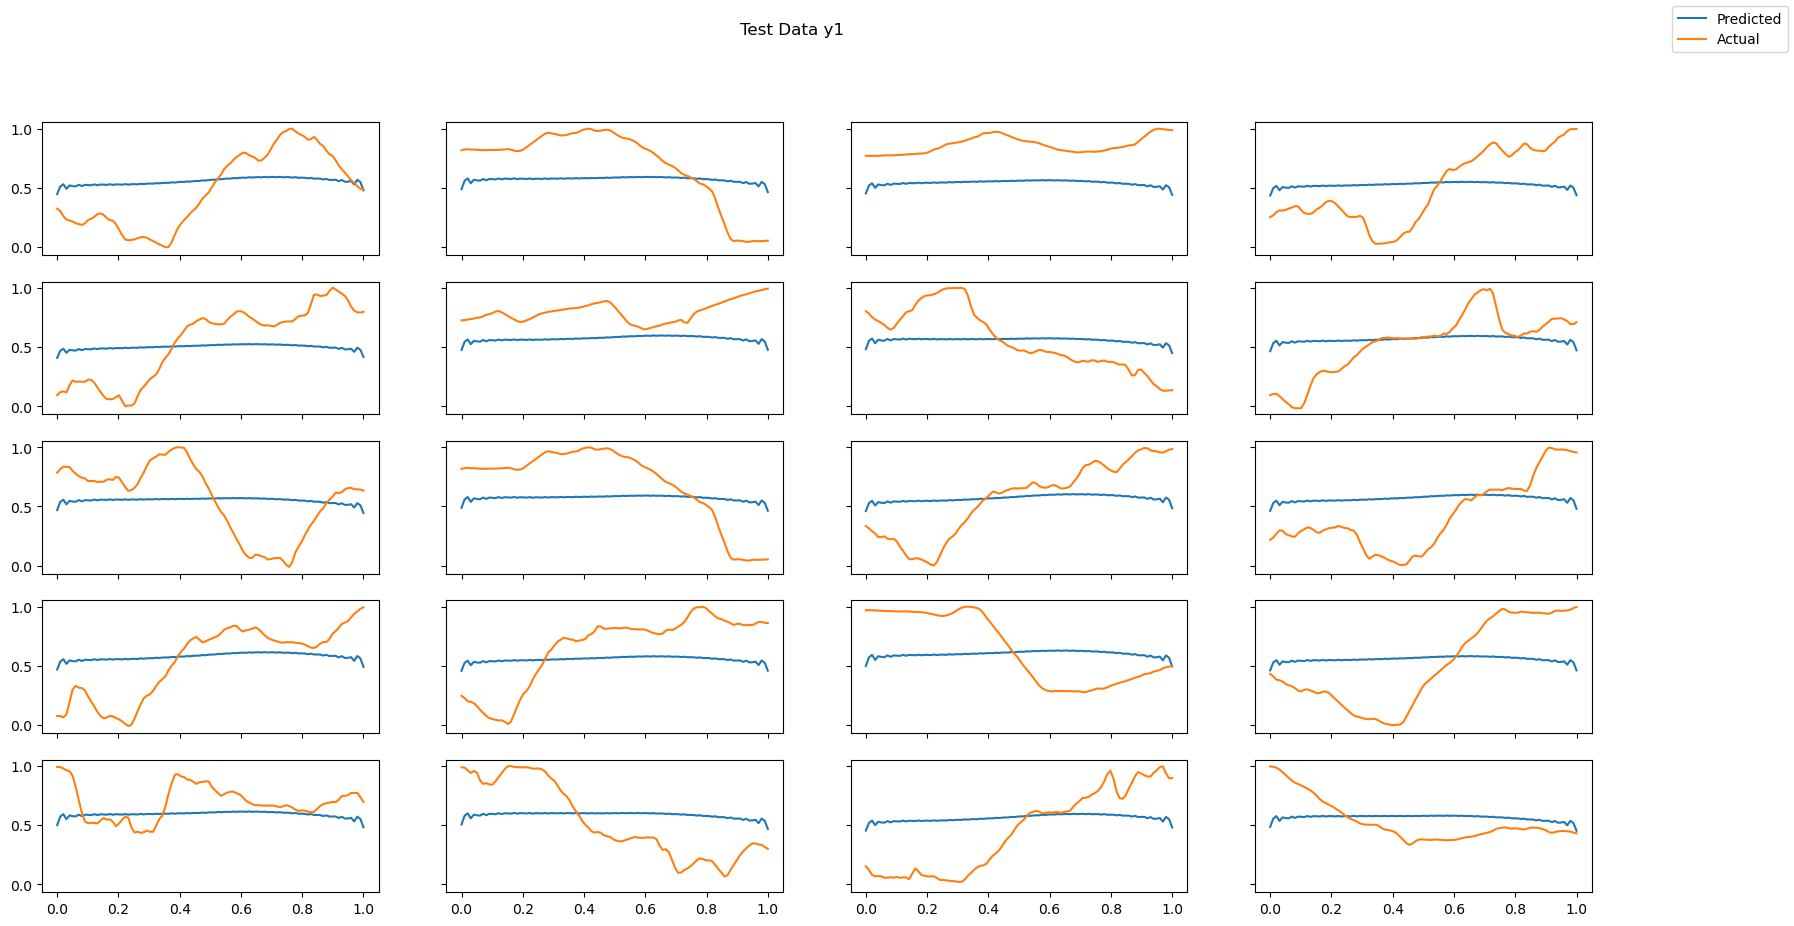

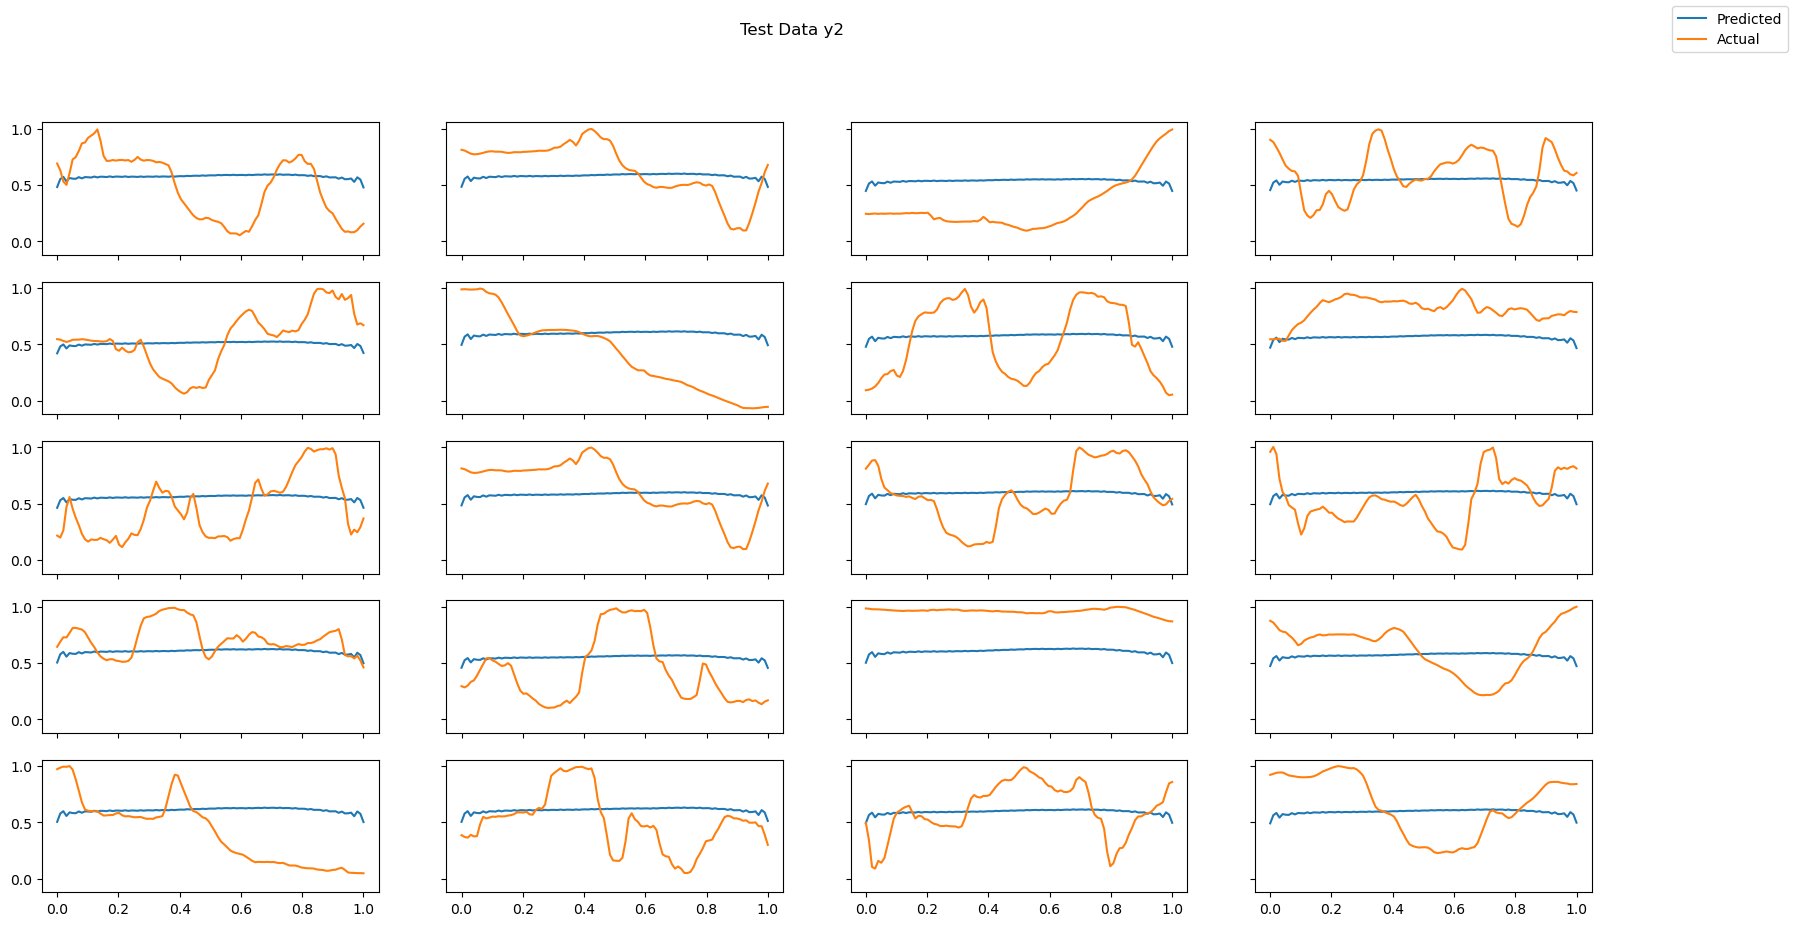

7.5868679121127345


In [101]:
title = ['Test Data y1', 'Test Data y2']
plot_predictions_multi_d(test_inp_B, test_out_B, train_inp_B_s, best_vech_L, best_u, best_D, 20, title, best_Gamma, k_mat)

In [102]:
vec_L = vech_to_vec(best_vech_L)
L = vec_L.reshape((n,n))
print(L)

[[ 7.36073021e-01 -1.39683334e-08 -1.93445896e-08 -1.47613095e-08
  -1.36768274e-08 -1.47568289e-08 -1.94510761e-08 -1.37322241e-08
  -1.41594016e-08 -1.88591203e-08 -1.42545073e-08 -1.30282191e-08
  -1.88409375e-08 -1.44031024e-08 -1.38755252e-08 -1.39184599e-08
  -1.94072550e-08 -1.90315034e-08 -1.94384114e-08 -7.36072719e-01
  -1.29887318e-08]
 [-1.39683334e-08  8.61279025e-01 -2.03477215e-08 -1.46269008e-08
  -1.49951900e-08 -1.46452732e-08 -2.03741837e-08 -1.49731179e-08
  -8.61278710e-01 -2.07862245e-08 -1.41472541e-08 -1.37676851e-08
  -2.07328075e-08 -1.42597985e-08 -1.45511573e-08 -1.45295619e-08
  -2.03715754e-08 -2.05128931e-08 -1.99161142e-08 -1.40864376e-08
  -1.37716910e-08]
 [-1.93445896e-08 -2.03477215e-08  3.81961006e-07 -2.04355410e-08
  -1.99560812e-08 -2.04548673e-08 -1.87615212e-08 -2.01195765e-08
  -2.03511058e-08 -1.75372686e-08 -1.98469528e-08 -1.78618706e-08
  -1.76138821e-08 -1.99507819e-08 -1.90281666e-08 -1.89876539e-08
  -1.87391933e-08 -1.77809264e-08 -1.7

In [103]:
def display_graph_with_thresh(vech_L, c_num):
    vec_L = vech_to_vec(vech_L)
    L = vec_L.reshape((n,n))
    W = np.diag(np.diag(L)) - L
    G = nx.Graph()
    for i in range(len(W)):
        G.add_node(i+1)
    for i in range(n):
        for j in range(i+1,n):
            if W[i][j] > 0:
                G.add_edge(i+1, j+1, weight=np.log10(W[i][j]))
    plt.figure()
    edges,weights = zip(*nx.get_edge_attributes(G,'weight').items())
    pos = nx.circular_layout(G)
    nx.draw_networkx(G, pos, font_color = 'white', node_shape = 'o', with_labels = True, node_color='b', edgelist=edges, edge_color=weights, width=3.0, edge_cmap=plt.cm.Blues)
    sorted_weights = sorted(weights)
    fig, ax = plt.subplots(figsize=(6, 1))
    fig.subplots_adjust(bottom=0.5)
    cmap = plt.cm.Blues
    bounds = np.arange(-c_num,1)
    norm = matplotlib.colors.BoundaryNorm(bounds, cmap.N)
    fig.colorbar(
        matplotlib.cm.ScalarMappable(cmap=cmap, norm=norm),
        cax=ax,
        boundaries=bounds,
        ticks=bounds,
        spacing='proportional',
        orientation='horizontal',
        label= 'Log scale',
    )

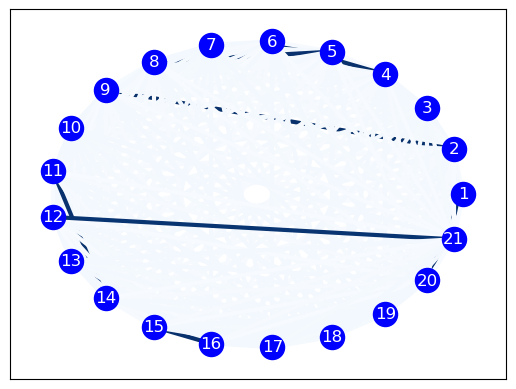

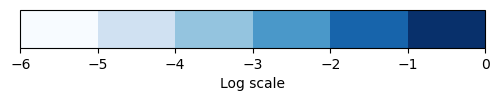

In [104]:
display_graph_with_thresh(best_vech_L, 6)

In [105]:
print(best_D)

[0.99947059 0.99951383 0.99950342 0.99946084 0.9994586  0.9994644
 0.99949585 0.99945199 0.99947298 0.99944612 0.99944878 0.99942249
 0.99944856 0.99949495 0.99943336 0.99944084 0.99951155 0.9995037
 0.99943897 0.9994761  0.99942261]
